In [ ]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = "."
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name

    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    headers = {"User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:47.0) Gecko/20100101 Firefox/47.0"}
    request = urllib.request.Request(url_base+file_name, headers=headers)
    response = urllib.request.urlopen(request).read()
    with open(file_path, mode='wb') as f:
        f.write(response)
    print("Done")

def download_mnist():
    for v in key_file.values():
       _download(v)

def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")

    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")

    return data

def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])

    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1

    return T


def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み

    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label :
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか

    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])




def relu(x):
    return np.maximum(0, x)

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def loss_function(y,t):
    #return sum(0.5*(y-t)**2)
    return -np.sum(t*np.log(y+1e-7))

def forward(network, x):
    W1 = network[0]
    W2 = network[1]
    b1 = network[2]
    b2 = network[3]
    y1 = relu(W1@x  + b1)
    y2 = softmax(W2@y1 + b2)    
    return y2, y1

#ランダムに入力を作る
def make_input(n):
    x=[]
    t=0
    for i in range(n):
        xi=int(np.random.random()<0.5)
        x.append(xi)
        t += xi*2**i
    x  = np.array(x)
    teach = []
    for i in range(2**n):
        teach.append(int(t==i))
    teach = np.array(teach)

    return x.reshape(n,1), teach.reshape(2**n,1)


def make_teach(x):
    teach = np.array([[int(x==0)],\
                      [int(x==1)],\
                      [int(x==2)],\
                      [int(x==3)],\
                      [int(x==4)],\
                      [int(x==5)],\
                      [int(x==6)],\
                      [int(x==7)],\
                      [int(x==8)],\
                      [int(x==9)]])
    return teach

def numerical_deff(y1,y2,h):
    return (y2-y1)/2/h

def calc_grad(network):
    index=0
    for W in network:
        network1 = copy(network)
        raw, col = np.shape(W)
        grad=np.zeros([raw, col])
        for m in range(raw):
            for n in range(col):
                #W1 = network[0]
                Wn = np.copy(W)
                Wn[m,n] = W[m,n] - h
                network1 = [W1n,W2,b1,b2]
                out1 = forward(network1, x) 
                loss1 = loss_function(out1, teach)
                W1n[m,n] = W1[m,n] + h
                network1 = [W1n,W2,b1,b2]
                out2 = forward(network1, x) 
                loss2 = loss_function(out2, teach)
                #print(loss2,loss1)
                grad1[m, n] = numerical_deff(loss1, loss2, h)
        index+=1





if __name__ == '__main__':
    init_mnist()

0 5 2.2443666047440094
1 0 2.2476224159060596
2 4 2.2637715474516313
3 1 2.2700287490384587
4 9 2.2734109061826935
5 2 2.2762068888705036
6 1 2.23292309698075
7 3 2.2861412878454415
8 1 2.1950011259206748
9 4 2.2495639574592343
10 3 2.2433577759415284
11 5 2.2616599173932523
12 3 2.1737716779116436
13 6 2.322930211810603
14 1 2.1787116645583153
15 7 2.334344233412479
16 2 2.2852303595010106
17 8 2.343084706298196
18 6 2.295643294912718
19 9 2.303186685981498
20 4 2.255681489330109
21 0 2.3102608079869915
22 9 2.267398925936372
23 1 2.181505355881864
24 1 2.1350198191176735
25 2 2.275331937693561
26 4 2.241432003571233
27 3 2.199929962389333
28 2 2.2136424311448515
29 7 2.3491624513819622
30 3 2.1621064339140057
31 8 2.359228105509908
32 6 2.3162969139082135
33 9 2.2739116809827906
34 0 2.3245598270325494
35 5 2.3339286541849824
36 6 2.2830775511831276
37 0 2.2879427327965645
38 7 2.3400652500564694
39 6 2.2480188399463774
40 1 2.1788993676747803
41 8 2.3508269609335444
42 7 2.307270928

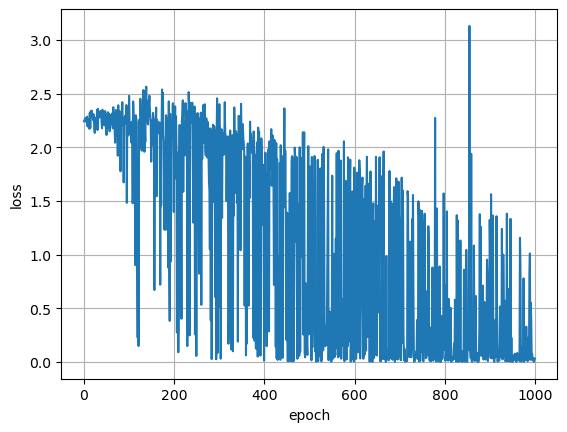

In [46]:
import numpy as np
import matplotlib.pyplot as plt

eta= 1e-3
#make Neural network
Nin = 784
M1 = 100
M2 = 10
W1 = eta*np.random.random([M1,Nin])
b1 = eta*np.random.random([M1,1])
W2 = eta*np.random.random([M2, M1])
b2 = eta*np.random.random([M2,1])
network = [W1,W2,b1,b2]

COUNT=[]
LOSS=[]

h=1e-3
rho = 0.05

train,test = load_mnist()

#学習
for i in range(1000):
    index = i
    #index = np.random.randint(0,59999)
    x = train[0][index]
    x = x.reshape(784,1)
    t = train[1][index]
    teach = make_teach(t)

    #img=x.reshape(28,28)
    #plt.imshow(img)
    #plt.show()

    W1 = network[0]
    W2 = network[1]
    b1 = network[2]
    b2 = network[3]

    #数値偏微分
    grad1=np.zeros([M1, Nin])
    raw, col = np.shape(W1)
    for m in range(raw):
        for n in range(col):
            W1 = network[0]
            W1n = np.copy(W1)
            W1n[m,n] = W1[m,n] - h
            network1 = [W1n,W2,b1,b2]
            out1 , mid= forward(network1, x) 
            loss1 = loss_function(out1, teach)
            W1n[m,n] = W1[m,n] + h
            network1 = [W1n,W2,b1,b2]
            out2 , mid= forward(network1, x) 
            loss2 = loss_function(out2, teach)
            grad1[m, n] = numerical_deff(loss1, loss2, h)

    grad2=np.zeros([M2, M1])
    for m in range(M2):
        for n in range(M1):
            W2 = network[1]
            W2n = np.copy(W2)
            W2n[m,n] = W2[m,n] - h
            network1 = [W1,W2n,b1,b2]
            out1 , mid= forward(network1, x) 
            loss1 = loss_function(out1, teach)
            W2n[m,n] = W2n[m,n] + 2*h
            network1 = [W1,W2n,b1,b2]
            out2, mid = forward(network1, x) 
            loss2 = loss_function(out2, teach)
            #print(loss2,loss1)
            grad2[m, n] = numerical_deff(loss1, loss2, h)

    grad3=np.zeros([M1, 1])
    for m in range(M1):
        for n in range(1):
            b1 = network[2]
            b1n = np.copy(b1)
            b1n[m,n] = b1[m,n] - h
            network1 = [W1,W2,b1n,b2]
            out1 , mid= forward(network1, x) 
            loss1 = loss_function(out1, teach)
            b1n[m,n] = b1n[m,n] + 2*h
            network1 = [W1,W2,b1n,b2]
            out2, mid = forward(network1, x) 
            loss2 = loss_function(out2, teach)
            #print(loss2,loss1)
            grad3[m, n] = numerical_deff(loss1, loss2, h)

    grad4=np.zeros([M2, 1])
    for m in range(M2):
        for n in range(1):
            b2 = network[3]
            b2n = np.copy(b2)
            b2n[m,n] = b2[m,n] - h
            network1 = [W1,W2,b1,b2n]
            out1, mid = forward(network1, x) 
            loss1 = loss_function(out1, teach)
            b2n[m,n] = b2n[m,n] + 2*h
            network1 = [W1,W2,b1,b2n]
            out2, mid = forward(network1, x) 
            loss2 = loss_function(out2, teach)
            #print(loss2,loss1)
            grad4[m, n] = numerical_deff(loss1, loss2, h)

    #重み更新
    W1 = W1 - rho*grad1
    W2 = W2 - rho*grad2
    b1 = b1 - rho*grad3
    b2 = b2 - rho*grad4

    #x, teach = make_input()
    network = [W1,W2,b1,b2]
    out, mid = forward(network, x) 
    loss = loss_function(out, teach)

    #print(i, teach.reshape(1,2**Nin), out.reshape(1,2**Nin), loss)
    print(i, t, loss)
    COUNT.append(i)
    LOSS.append(loss)
    
plt.plot(COUNT, LOSS)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()
    


In [ ]:
#学習後のニューラルネットで確認
x, teach = make_input(Nin)
network = [W1,W2,b1,b2]
out, d = forward(network, x)

print("input", x.reshape(1,Nin))
print("output\n", np.round(out.reshape(1,2**Nin)))

In [ ]:
Nin = 4
M1 = 10
M2 = 2**Nin
W1 = np.random.random([M1,Nin])
b1 = np.random.random([M1,1])
W2 = np.random.random([M2, M1])
b2 = np.random.random([M2,1])
network2 = [W1,W2,b1,b2]
x, teach = make_input(Nin)
out, d = forward(network2, x)
print(np.round(out*100))

In [ ]:
#28*28=784
train,test = load_mnist()
x=train[0][1].reshape(784,1)

eta = 1e-2
Nin = 784
M1 = 350
M2 = 10
W1 = eta*np.random.random([M1,Nin])
b1 = eta*np.random.random([M1,1])
W2 = eta*np.random.random([M2, M1])
b2 = eta*np.random.random([M2,1])
network2 = [W1,W2,b1,b2]
out, d = forward(network2, x)
print(np.round(out*100))

In [ ]:
28*28